# Version 1.0 Model Predictions

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

## Import Data Sets
Here we will import `NetC_Expanded` which is data seperated by management style, result and slavage status, and we will import the predictors and join those datasets.

In [2]:
netc_expanded = pd.read_csv('../Data/NetC_Expanded.csv')
netc_expanded = netc_expanded.drop(['Unnamed: 0'], axis=1)
netc_expanded.head()

,TimeStep,Risk_Cat,Stand_ID,Salvage,Management,Result
0,0,4,0023200606030102900043,True,Heavy,-249.287884
1,0,4,0023200606030102900043,True,NoMgmt,-321.931519
2,0,4,0023200606030102900043,True,Moderate,-276.111511
3,0,4,0023200606030102900043,True,Comm-Ind,-250.583375
4,0,4,0023200606030102900043,True,HighGrade,-293.426896


In [3]:
predictors = pd.read_csv('../Data/Predict_SBW_wCarbon_T0to40.csv')
predictors = predictors.rename(columns={'StandID': 'Stand_ID'})
predictors = predictors.set_index('Stand_ID')
predictors = predictors[["BF_BA","OHost_BA","BF_Stock","OHost_Stock","NonHost_Stock","BF_QMD","ELEV","SLOPE","ASPECT","LAT","SiteInd"]]
predictors.head()

,BF_BA,OHost_BA,BF_Stock,OHost_Stock,NonHost_Stock,BF_QMD,ELEV,SLOPE,ASPECT,LAT,SiteInd
Stand_ID,,,,,,,,,,,
0023200606030200300067,NaN,0.498332,NaN,0.883600,56.9255,NaN,580,5.0,240.0,46.14358,NaN
0023200606030200300826,3.899610,11.890484,21.8437,0.885569,18.6635,4.965398,1170,0.0,0.0,47.19684,28.0
0023200606030200300924,0.036869,7.443510,0.2679,1.166825,3.8019,2.600000,990,0.0,0.0,46.64171,33.0
0023200606030301901813,0.967649,1.368845,63.7216,1.609179,12.1858,2.106063,180,0.0,0.0,45.09319,40.0
0023200606030400901513,3.352901,6.679677,73.4189,1.397641,18.2434,3.405766,250,0.0,0.0,44.73563,NaN


## Selecting Management Style 
Gong to define a management style upfront to create rule set

In [4]:
MANAGEMENT_STYLE = 'NoMgmt'

mgmt_df = netc_expanded[netc_expanded['Management'] == MANAGEMENT_STYLE]

Here is an example of what we see in the mgmt_df after grouping stand_id and getting the value at timestep 40

In [5]:
x = mgmt_df[(mgmt_df['Stand_ID'] == '0023200606030400901513') & 
            (mgmt_df['TimeStep'] == 40)].groupby('Salvage').head().set_index('Salvage')
x

,TimeStep,Risk_Cat,Stand_ID,Management,Result
Salvage,,,,,
True,40,1,0023200606030400901513,NoMgmt,-340.709429
False,40,1,0023200606030400901513,NoMgmt,-286.246874


Choosing a left join to drop `na` for 

In [6]:
def get_mgmt_df(target_df, pred_df, tol):
    """
    Returns labeled DF for salvage and non salvage decisions
    """
    temp_df = pd.DataFrame(columns=['Stand_ID', 'Salvage_Good', 'Result'])
    for stand in target_df['Stand_ID'].unique():
        
        group_df = target_df[(target_df['Stand_ID'] == stand)
                             & (target_df['TimeStep'] == 40)]
        group_df = group_df.set_index('Salvage')
        
        # calculate diff
        # This assumes that best is always negative
        diff = group_df['Result'].min() - group_df['Result'].max()
        
        # If index is True where min is acheived
        if group_df['Result'].idxmin():  # and diff > tol:
            temp_df = temp_df.append(
                pd.DataFrame({
                    'Stand_ID': [stand],
                    'Salvage_Good': [True],
                    'Result': [group_df['Result'].min()],
                    'diff': [diff]
                })
            )
        else:
            temp_df = temp_df.append(
                pd.DataFrame({
                    'Stand_ID': [stand],
                    'Salvage_Good': [False],
                    'Result': [group_df['Result'].min()],
                    'diff': [diff]
                })
            )
            
    temp_df = temp_df.set_index('Stand_ID')
    return pd.merge(pred_df, temp_df, on="Stand_ID", right_index=True)

In [7]:
heavy_df = get_mgmt_df(mgmt_df, predictors, 0)

In [8]:
heavy_df = heavy_df.fillna(heavy_df.median())

In [9]:
heavy_df.head()

,BF_BA,OHost_BA,BF_Stock,OHost_Stock,NonHost_Stock,BF_QMD,ELEV,SLOPE,ASPECT,LAT,SiteInd,Salvage_Good,Result,diff
Stand_ID,,,,,,,,,,,,,,
0023200606030200300067,2.325367,0.498332,11.4585,0.883600,56.9255,5.490730,580,5.0,240.0,46.14358,42.0,True,-664.759580,-76.262993
0023200606030200300826,3.899610,11.890484,21.8437,0.885569,18.6635,4.965398,1170,0.0,0.0,47.19684,28.0,True,-378.709805,-37.679733
0023200606030200300924,0.036869,7.443510,0.2679,1.166825,3.8019,2.600000,990,0.0,0.0,46.64171,33.0,True,-384.995331,-70.047821
0023200606030301901813,0.967649,1.368845,63.7216,1.609179,12.1858,2.106063,180,0.0,0.0,45.09319,40.0,True,-537.624581,-135.395987
0023200606030400901513,3.352901,6.679677,73.4189,1.397641,18.2434,3.405766,250,0.0,0.0,44.73563,42.0,True,-340.709429,-54.462554


Here we can see that the option to not salvage benefited more than salvaging, so in this case we won't offer salvage credit.

## Split Data

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [48]:
X = heavy_df.drop(['Salvage_Good', 'Result'], axis=1)
y = heavy_df[['Salvage_Good']].astype('int')

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [50]:
train = X_train.copy()
train['Salvage_Good'] = y_train.to_numpy()

## Baselines

`IP` is an interpretability constant since net saved emissions is always large

In [51]:
IP = 10000

In [52]:
assess_df = mgmt_df.set_index('Stand_ID')
assess_df = assess_df[assess_df['TimeStep'] == 40]
assess_df = assess_df[['Salvage', 'Result']]

assess_df = pd.merge(assess_df, X_test, on="Stand_ID")

### (1) Don't Salvage At All

In [53]:
no_salvage = assess_df[(assess_df['Salvage'] == False)]
no_salvage_score = no_salvage['Result'].sum()
no_salvage_score / IP

-60.710494488870005

### (2) Only Salvage

In [54]:
only_salvage = assess_df[(assess_df['Salvage'] == True)]
only_salvage_score = only_salvage['Result'].sum()
only_salvage_score / IP

-65.92417683484

### (3) Optimal

In [55]:
optimal = pd.merge(assess_df, heavy_df['Salvage_Good'], on="Stand_ID")
salvage_optimal = optimal[(optimal['Salvage_Good'] == True) & 
                          (optimal['Salvage'] == True)].Result.sum()
no_salvage_optimal = optimal[(optimal['Salvage_Good'] == False) & 
                             (optimal['Salvage'] == False)].Result.sum()
(salvage_optimal + no_salvage_optimal) / IP

-66.24576878969002

### SKOPE Rules

In [56]:
from imodels.rule_set.skope_rules import SkopeRulesClassifier
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

In [57]:
try:
    X_train = X_train.drop(['diff'], axis=1)
    X_test = X_test.drop(['diff'], axis=1)
except KeyError:
    pass

In [251]:
clf = SkopeRulesClassifier(
    max_depth_duplication=None,
    n_estimators=1,
    precision_min=0.8,
    recall_min=0, 
)
clf.fit(X_train, y_train.to_numpy().ravel())

SkopeRulesClassifier(n_estimators=1, precision_min=0.8, recall_min=0)

In [264]:
y_train_pred = clf.predict(X_train)
accuracy_score(y_train, y_train_pred)

0.7401015228426396

In [252]:
y_pred = clf.predict_top_rules(X_test, 3)
accuracy_score(y_test, y_pred)

0.6886409736308317

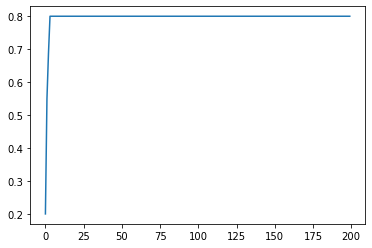

In [247]:
def show_rules():
    """ 
    plot rules over time
    """
    preds = [accuracy_score(y_train, clf.predict_top_rules(X_train, i)) for i in range(200)]
    plt.plot([i for i in range(len(preds))],  preds)

show_rules()

In [253]:
for rule in clf.rules_:
    print(rule)

('feature_2 > 11.663099765777588 and feature_5 <= 6.892452955245972 and feature_7 <= 72.5', (0.9315960912052117, 0.45980707395498394, 1))
('feature_2 <= 11.663099765777588 and feature_3 <= 0.9533678293228149 and feature_5 <= 5.477818012237549', (0.859504132231405, 0.16720257234726688, 1))
('feature_2 > 11.663099765777588 and feature_5 <= 9.002291202545166 and feature_5 > 6.892452955245972', (0.8245614035087719, 0.07556270096463022, 1))
('feature_2 <= 11.663099765777588 and feature_3 > 0.9533678293228149 and feature_5 <= 5.482783079147339', (0.8085106382978723, 0.06109324758842444, 1))


In [254]:
def print_columns(X, cols):
    print("RULES LEARNED: ")
    for col in cols:
        print("feature_{} is {}".format(col, X_train.columns[col]))
        
        
print_columns(X_test, [0,2,5])

RULES LEARNED: 
feature_0 is BF_BA
feature_2 is BF_Stock
feature_5 is BF_QMD


In [255]:
np.unique(y_pred, return_counts=True)

(array([0, 1]), array([439, 547]))

### (4) Skope Rules (assess savings)

In [230]:
from sklearn.metrics import precision_score, recall_score

In [262]:
def assess_savings(X_test, y_pred):
    """
    Append predicitons and sum slavage/no salvage results 
    """
    # add predictions
    test_df = X_test.copy()
    test_df['preds'] = y_pred

    # merge with management 
    temp = pd.merge(assess_df, test_df, on="Stand_ID")

    salvage_sum = temp[(temp['Salvage'] == True) & (temp['preds'] == 1)].Result.sum()
    no_salvage_sum = temp[(temp['Salvage'] == False) & (temp['preds'] == 0)].Result.sum()

    return salvage_sum + no_salvage_sum

In [263]:
skope_rules_score = assess_savings(X_test, y_pred)
skope_rules_score / IP

-65.04284340717001

In [260]:
precision_score(y_test, y_pred)

0.923217550274223

In [261]:
recall_score(y_test, y_pred)

0.6558441558441559

## Boolean Compressed Sensing 

### Naive Split

In [30]:
def create_design_matrices(df, quantiles):
    """Create A_N and A_P"""
    measurement = pd.DataFrame()
    measurement['Salvage_Good'] = df['Salvage_Good']
    labels = ['Q' + str(q) for q in range(1, quantiles+1)]
    bins = []

    for col in df:
        if col == 'Result' or col == 'Salvage_Good':
            continue

        try:
            measurement[col], b = pd.qcut(df[col], quantiles, labels=labels, retbins=True)
            bins.append(b)
        except ValueError:
            labels = ['Q' + str(q) for q in range(1, quantiles-1)]
            measurement[col] = pd.qcut(heavy_df[col], quantiles-2, labels=labels)
            labels = ['Q' + str(q) for q in range(1, quantiles)]

    measurement = pd.get_dummies(measurement, drop_first=False)
    A_p = measurement[measurement['Salvage_Good'] == 1].drop('Salvage_Good', axis=1)
    A_n = measurement[measurement['Salvage_Good'] != 1].drop('Salvage_Good', axis=1)


    return A_p.to_numpy(), A_n.to_numpy(), measurement.to_numpy(), list(A_p.columns), bins

In [31]:
def create_test_matrix(df, features, bins):
    temp = pd.DataFrame()
    for i, col in enumerate(df):
        temp[features[i]] = df[col].apply(
            lambda x: 1 if x >= bins[i][1] else 0
        )

    return temp

In [32]:
A_p, A_n, measurement, features, bins = create_design_matrices(train, 2)

In [33]:
test_design = create_test_matrix(X_test, features, bins)

### Rule Set using Rule Fit 

### Learn Sparse Rules

In [34]:
import gurobipy as gp
from gurobipy import GRB

In [35]:
m = gp.Model("rule-extraciton")


--------------------------------------------
--------------------------------------------

Using license file /home/sean/gurobi.lic
Academic license - for non-commercial use only - expires 2020-12-08


In [36]:
w = m.addMVar(shape=A_p.shape[1], vtype=GRB.BINARY, name="weights")
psi_p = m.addMVar(shape=A_p.shape[0], name="psi_p")
psi_n = m.addMVar(shape=A_n.shape[0], name="psi_n")

In [37]:
m.addConstr(w <= 1.0)
m.addConstr(w >= 0.0)
m.addConstr(psi_p <= 1)
m.addConstr(psi_p >= 0)
m.addConstr(psi_n >= 0)
m.addConstr(A_p @ w + psi_p >= 1.0)
m.addConstr(A_n @ w == psi_n)
m.update()

In [38]:
m.setObjective(sum(w) + 1000 * (sum(psi_p) + sum(psi_n)), GRB.MINIMIZE)

In [39]:
m.optimize()

Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 11055 rows, 3964 columns and 58335 nonzeros
Model fingerprint: 0x3b5dbf0d
Variable types: 3940 continuous, 24 integer (24 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 1138003.0000
Presolve removed 9855 rows and 2740 columns
Presolve time: 0.03s
Presolved: 1200 rows, 1224 columns, 15600 nonzeros
Variable types: 0 continuous, 1224 integer (1224 binary)

Root relaxation: objective 8.130020e+05, 697 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    813002.00000 813002.000  0.00%     -    0s

Explored 0 nodes (697 simplex it

In [40]:
m.getVarByName("weights[0]")
for i in range(measurement.shape[1]):
    print(m.getVarByName("weights[" + str(i) + "]"))

<gurobi.Var weights[0] (value -0.0)>
<gurobi.Var weights[1] (value 0.0)>
<gurobi.Var weights[2] (value 0.0)>
<gurobi.Var weights[3] (value -0.0)>
<gurobi.Var weights[4] (value -0.0)>
<gurobi.Var weights[5] (value 0.0)>
<gurobi.Var weights[6] (value 0.0)>
<gurobi.Var weights[7] (value -0.0)>
<gurobi.Var weights[8] (value -0.0)>
<gurobi.Var weights[9] (value 0.0)>
<gurobi.Var weights[10] (value 0.0)>
<gurobi.Var weights[11] (value -0.0)>
<gurobi.Var weights[12] (value 0.0)>
<gurobi.Var weights[13] (value -0.0)>
<gurobi.Var weights[14] (value 1.0)>
<gurobi.Var weights[15] (value 1.0)>
<gurobi.Var weights[16] (value 0.0)>
<gurobi.Var weights[17] (value -0.0)>
<gurobi.Var weights[18] (value -0.0)>
<gurobi.Var weights[19] (value 0.0)>
<gurobi.Var weights[20] (value 0.0)>
<gurobi.Var weights[21] (value -0.0)>
<gurobi.Var weights[22] (value 0.0)>
<gurobi.Var weights[23] (value -0.0)>
None


## Evaluate

### Raw Accuracy

In [41]:
features[18]

'LAT_Q1'

In [42]:
features[19]

'LAT_Q2'

## Analysis 